# Tracking a moving stystem
## Outlier covariance

We consider a state-space model of the form
$$
\begin{aligned}
    p(z_t \vert z_{t-1}) &= {\cal N}(z_t \vert F z_{t-1}, Q_t)\\
    p(y_t \vert z_t) &= \text{St}(y_t \vert  H_t z_t, R_t, \nu)
\end{aligned}
$$

In [1]:
import jax
import datagen
import pandas as pd
import numpy as np
import jax.numpy as jnp
import seaborn as sns
import matplotlib.pyplot as plt


from functools import partial
from rebayes_mini import callbacks
from bayes_opt import BayesianOptimization
from rebayes_mini.datasets import linear_ssm
from rebayes_mini.methods import student_t_filter as stf
from rebayes_mini.methods import gauss_filter as kf
from rebayes_mini.methods import robust_filter as rkf
from rebayes_mini.methods import generalised_bayes_filter as gbf

2023-12-27 15:26:41.855319: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

plt.rcParams["font.size"] = 18
cmap = {
    "ANN12": "crimson",
    "IMQF": "dodgerblue",
    "KF": "lightseagreen",
    "M-KF": "gold",
}

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
key = jax.random.PRNGKey(314)

## Multiple samples

In [5]:
delta = 0.1
dynamics_covariance = 0.1
obs_covariance = 10.0
dgen = datagen.GaussOutlierMovingObject2D(
    delta, dynamics_covariance, obs_covariance,
    outlier_proba=0.05,
    outlier_scale=100.0,
)


In [6]:
initial_mean = initial_mean = jnp.array([0.0, 0.0, 1.0, 1.0])
n_steps = 500

n_samples = 100
colors = plt.cm.tab10(jnp.arange(n_samples))
colors = plt.cm.viridis(jnp.linspace(0, 1, n_samples))
keys = jax.random.split(key, n_samples)
datasets = jax.vmap(dgen.sample, in_axes=(0, None, None))(keys, initial_mean, n_steps)

yv = datasets["observed"]
state = datasets["latent"]

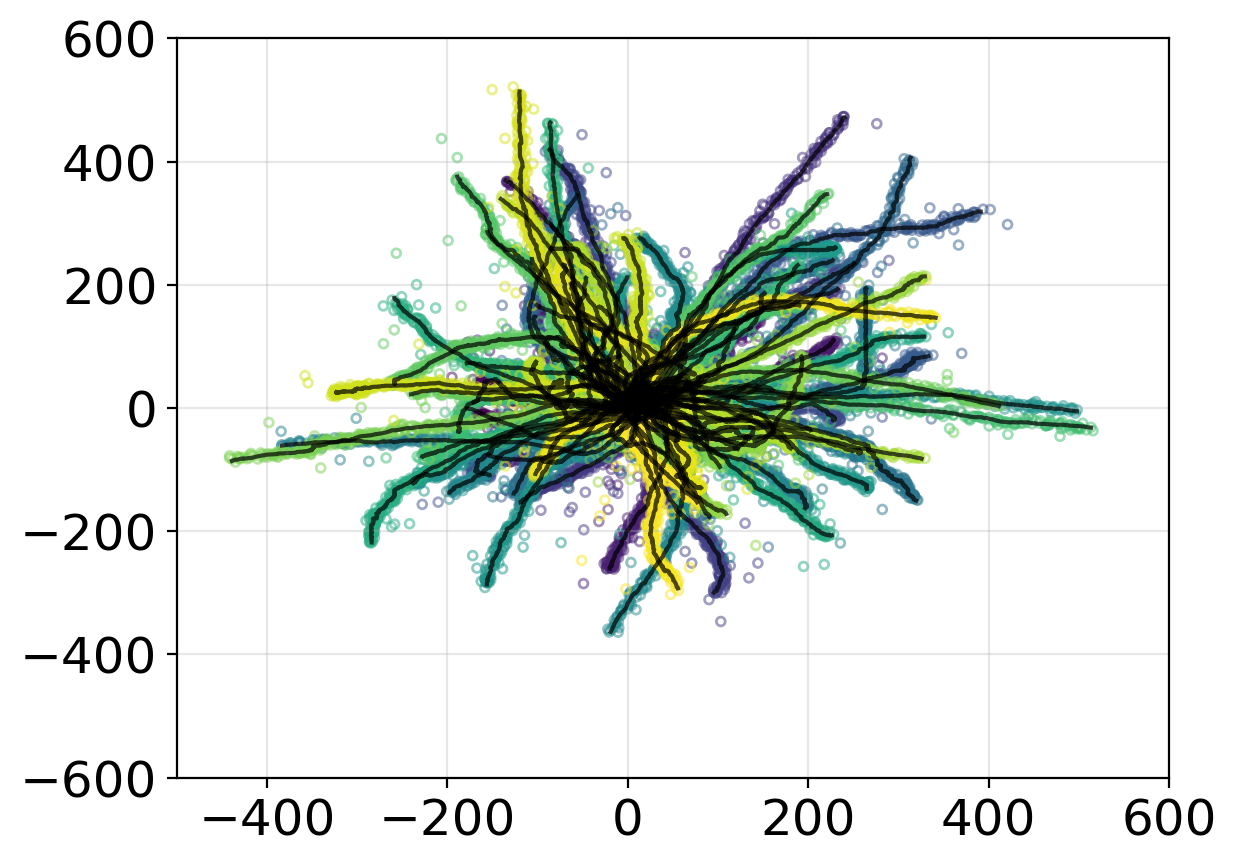

In [7]:
for i, color in enumerate(colors):
    dataset = jax.tree_map(lambda x: np.array(x[i]), datasets)
    plt.plot(*dataset["latent"][:, :2].T, c="black", alpha=0.7)
    plt.scatter(*dataset["observed"].T, edgecolor=color, color="none", s=10, alpha=0.5)
    
plt.xlim(-500, 600)
plt.ylim(-600, 600)
plt.grid(alpha=0.3)

## Kalman filter

In [8]:
agent_kf = kf.KalmanFilter(
    dgen.transition_matrix,
    dgen.dynamics_covariance,
    dgen.observation_covariance
)


init_bel = agent_kf.init_bel(initial_mean, cov=1.0)

vscan = jax.vmap(
    partial(agent_kf.scan, callback_fn=callbacks.get_updated_mean),
    in_axes=(None, 0, None)
)
_, hist_bel_kf_runs = vscan(
    init_bel, yv, dgen.projection_matrix
)

In [9]:
diff_kf = jnp.power(hist_bel_kf_runs - datasets["latent"], 2)
jnp.sqrt(diff_kf.sum(axis=1)).mean(axis=0)

Array([59.01096 , 58.644497, 40.810135, 41.099766], dtype=float32)

## Robust KF --- agamenoni 2012

In [10]:
@partial(jax.vmap, in_axes=(None, 0, 0))
def vmap_filter_rkf(noise_scaling, measurements, state):
    agent_rkf = rkf.RobustKalmanFilter(
        dgen.transition_matrix,
        dgen.dynamics_covariance,
        dgen.observation_covariance,
        n_inner=2,
        noise_scaling=noise_scaling
    )

    
    
    init_bel = agent_rkf.init_bel(initial_mean, cov=1.0)
    filterfn = partial(agent_rkf.scan, callback_fn=callbacks.get_updated_mean)
    _, hist = filterfn(init_bel, measurements, dgen.projection_matrix)
    
    err = jnp.sqrt(jnp.power(hist - state, 2).sum(axis=0))
    return err, hist

@jax.jit
def bo_filter_rkf(noise_scaling):
    err, _ = vmap_filter_rkf(noise_scaling, yv[:1], state[:1])
    return -err.mean(axis=0).max()

In [11]:
%%time
bo = BayesianOptimization(
    bo_filter_rkf,
    pbounds={
        "noise_scaling": (1e-6, 20)
    },
    random_state=314,
    verbose=1
)
bo.maximize(init_points=20, n_iter=35)

|   iter    |  target   | noise_... |
-------------------------------------
| 2         | -40.36    | 11.77     |
| 14        | -40.03    | 7.72      |
| 22        | -40.03    | 7.722     |
CPU times: user 3min 10s, sys: 3min 40s, total: 6min 51s
Wall time: 6.64 s


In [12]:
noise_scaling = bo.max["params"]["noise_scaling"]
_, hist_bel_rkf_runs = vmap_filter_rkf(noise_scaling, yv, state)
diff_rkf = jnp.power(hist_bel_rkf_runs - state, 2)

jnp.sqrt(diff_rkf.sum(axis=1)).mean(axis=0)

Array([48.61583 , 48.022175, 37.081944, 36.887836], dtype=float32)

## Weighted (IMQ) Kalman Filter

In [13]:
def link(z, _):
    mean = dgen.projection_matrix @ z
    return mean


@partial(jax.vmap, in_axes=(None, 0, 0))
def vmap_filter_imqf(soft_threshold, measurements, state):
    nsteps = len(measurements)
    agent_imq = gbf.IMQFilter(
        link,
        dynamics_covariance=dgen.dynamics_covariance,
        observation_covariance=dgen.observation_covariance,
        soft_threshold=soft_threshold,
        transition_matrix=dgen.transition_matrix,
    )
    init_bel = agent_imq.init_bel(initial_mean, cov=1.0)
    filterfn = partial(agent_imq.scan, callback_fn=callbacks.get_updated_mean)
    _, hist = filterfn(init_bel, measurements, jnp.ones(n_steps))

    err = jnp.sqrt(jnp.power(hist - state, 2).sum(axis=0))
    return err, hist


@jax.jit
def bo_filter_imqf(soft_threshold):
    err, _ = vmap_filter_imqf(soft_threshold, yv[:1], state[:1])
    return -err.mean(axis=0).max()

In [14]:
%%time
bo = BayesianOptimization(
    bo_filter_imqf,
    pbounds={
        "soft_threshold": (1e-6, 20)
    },
    random_state=314,
    verbose=1
)
bo.maximize(init_points=20, n_iter=30)

|   iter    |  target   | soft_t... |
-------------------------------------
| 2         | -33.44    | 11.77     |
| 3         | -33.26    | 5.301     |
| 14        | -33.19    | 7.72      |
| 25        | -33.18    | 6.81      |
| 34        | -33.17    | 7.259     |
| 48        | -33.16    | 7.036     |
CPU times: user 3min 22s, sys: 3min 44s, total: 7min 7s
Wall time: 6.68 s


In [15]:
soft_threshold = bo.max["params"]["soft_threshold"]
_, hist_bel_imqf_runs = vmap_filter_imqf(soft_threshold, yv, state)
diff_imq = jnp.power(hist_bel_imqf_runs - state, 2)

jnp.sqrt(diff_imq.sum(axis=1)).mean(axis=0)

Array([32.274918, 32.296906, 31.214115, 31.732836], dtype=float32)

## Robust KF -- mahalanobis-based thresholding

In [16]:
def latent_fn(z):
    return dgen.transition_matrix @ z

def measurement_fn(z, _):
    return dgen.projection_matrix @ z

In [17]:
@partial(jax.vmap, in_axes=(None, 0, 0))
def vmap_filter_mah_ekf(threshold, measurements, state):
    agent_mahfilter = rkf.ExtendedThresholdedKalmanFilter(
        latent_fn, measurement_fn,
        dynamics_covariance=dgen.dynamics_covariance,
        observation_covariance=dgen.observation_covariance,
        threshold=threshold
    )
    
    init_bel = agent_mahfilter.init_bel(initial_mean, cov=1.0)
    
    _, hist = agent_mahfilter.scan(
        init_bel, measurements, jnp.ones(n_steps), callback_fn=callbacks.get_updated_mean
    )

    err = jnp.sqrt(jnp.power(hist - state, 2).sum(axis=0))
    return err, hist


@jax.jit
def bo_filter_mah_ekf(threshold):
    err, _ = vmap_filter_mah_ekf(threshold, yv[:1], state[:1])
    return -err.mean(axis=0).max()

In [18]:
%%time
bo = BayesianOptimization(
    bo_filter_mah_ekf,
    pbounds={
        "threshold": (1e-6, 20)
    },
    random_state=314,
    verbose=1
)
bo.maximize(init_points=20, n_iter=30)

|   iter    |  target   | threshold |
-------------------------------------
| 2         | -35.33    | 11.77     |
| 3         | -33.13    | 5.301     |
| 13        | -31.95    | 2.446     |
CPU times: user 3min 5s, sys: 3min 28s, total: 6min 34s
Wall time: 6.17 s


In [19]:
threshold = bo.max["params"]["threshold"]
_, hist_bel_mah_ekf_runs = vmap_filter_mah_ekf(threshold, yv, state)
diff_mah_ekf = jnp.power(hist_bel_mah_ekf_runs - state, 2)

jnp.sqrt(diff_mah_ekf.sum(axis=1)).mean(axis=0)

Array([124.1499  ,  85.87283 ,  34.61533 ,  34.293167], dtype=float32)

## Huang's 2016 — scale / dof

In [20]:
def latent_fn(z):
    return dgen.transition_matrix @ z

def measurement_fn(z, _):
    return dgen.projection_matrix @ z

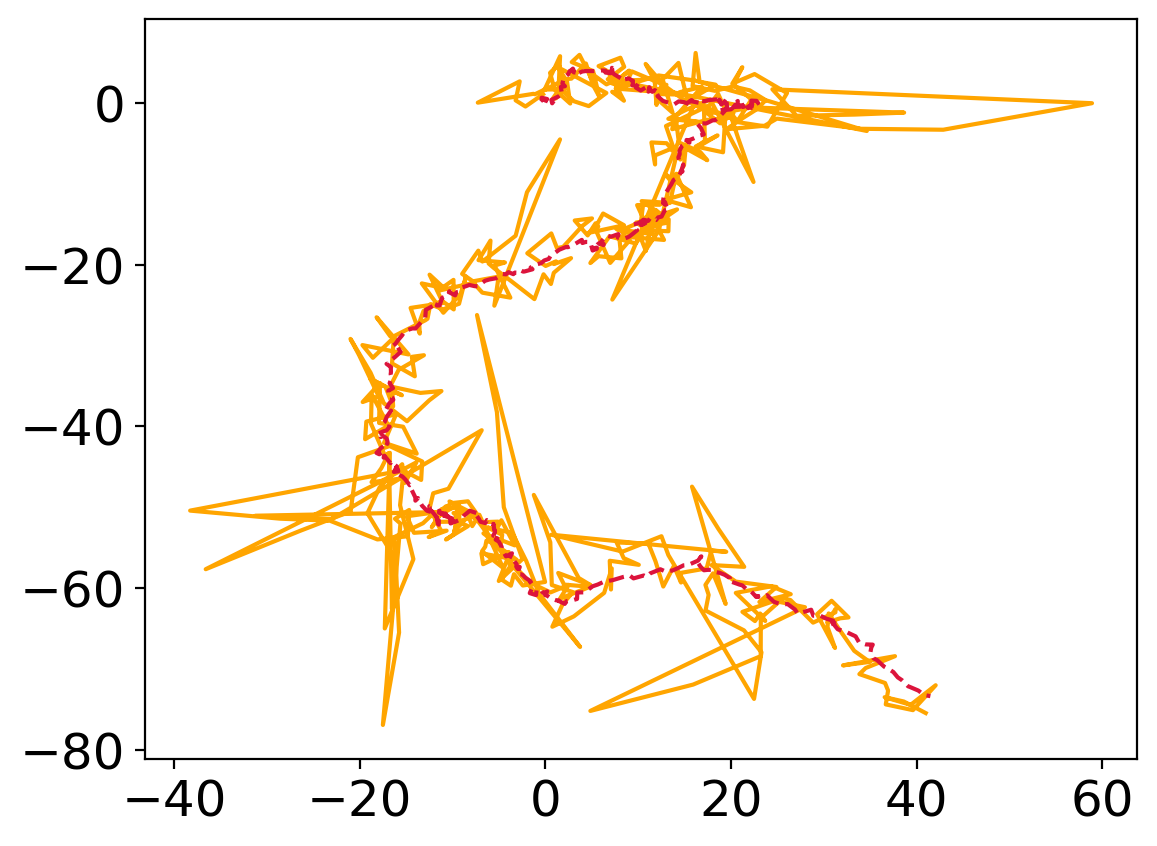

In [21]:
agent_scale_dof = rkf.RobustStFilter(
    latent_fn, measurement_fn,
    dynamics_covariance=dgen.dynamics_covariance,
    n_inner=2
)

bel_init = agent_scale_dof.init_bel(
    mean=initial_mean,
    covariance=1.0,
    obs_cov_scale=2,
    obs_cov_dof=1,
    dof_rate=4,
    dof_shape=2.0,
    rho=1 - np.exp(-5),
    dim_obs=2
)

ix = 11
bel_final, state_est = agent_scale_dof.scan(bel_init, yv[ix], jnp.ones(n_steps), callback_fn=callbacks.get_updated_mean)

plt.plot(*state_est[:, :2].T, c="orange")
plt.plot(*state[ix][:, :2].T, c="crimson", linestyle="--")

## Plot comparison

In [23]:
part_imq = pd.DataFrame(np.array(diff_imq.sum(axis=1))).melt()
part_imq["method"] = "IMQF"

part_rkf = pd.DataFrame(np.array(diff_rkf.sum(axis=1))).melt()
part_rkf["method"] = "ANN12"

part_kf = pd.DataFrame(np.array(diff_kf.sum(axis=1))).melt()
part_kf["method"] = "KF"

part_mekf = pd.DataFrame(np.array(diff_mah_ekf.sum(axis=1))).melt()
part_mekf["method"] = "M-KF"

In [24]:
diff_df = pd.concat([part_imq, part_rkf, part_kf, part_mekf], axis=0)
diff_df = diff_df.rename(
    {
        "variable": "state",
        "value": "error"
    },
    axis=1
)

diff_df["state"] = diff_df["state"].apply(lambda x: rf"$\theta_{x}$")

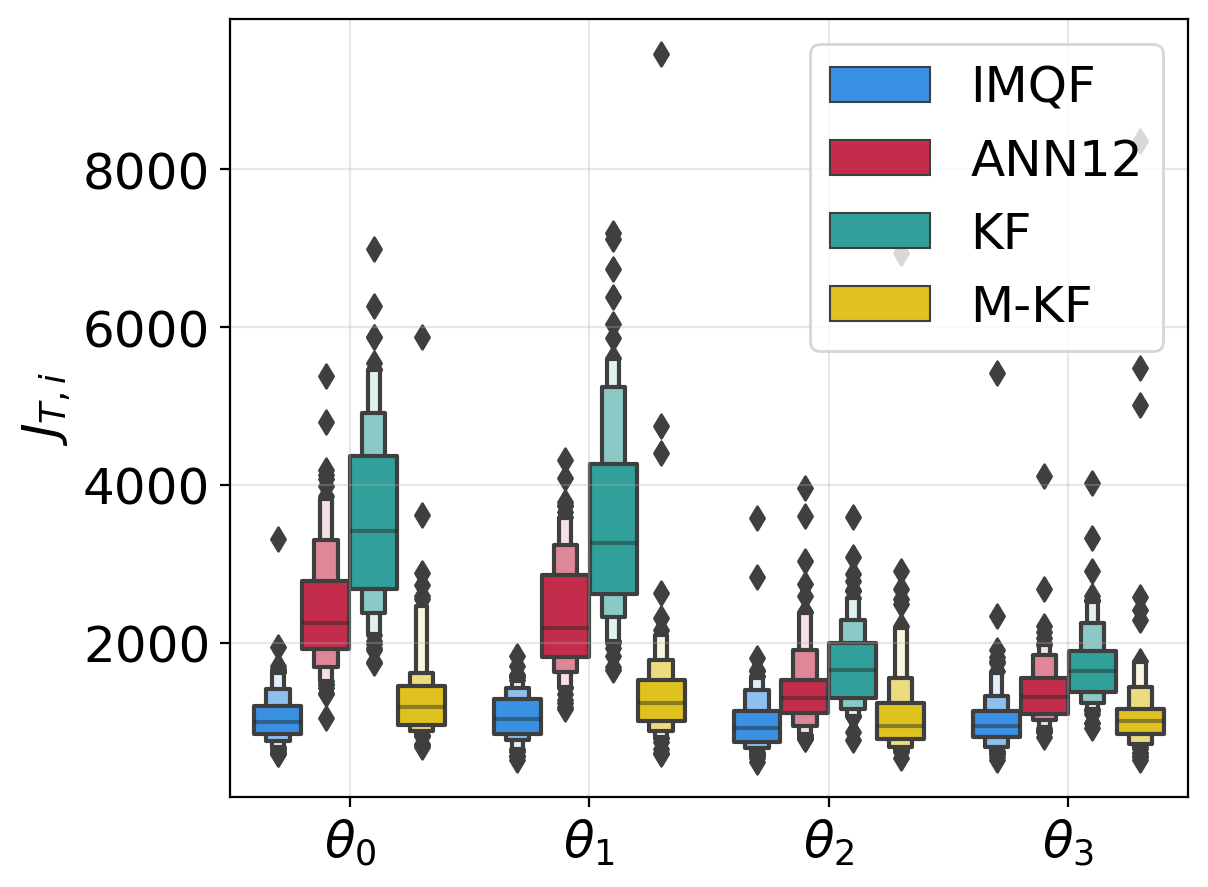

In [25]:
sns.boxenplot(
    y="error",
    x="state",
    hue="method",
    data=diff_df.query("error < 1e4"),
    palette=cmap,
)
plt.legend()
plt.xlabel("")
plt.ylabel("$J_{T,i}$")
plt.grid(alpha=0.3)
plt.tight_layout()
# plt.yscale("log")
plt.savefig("./figures/2d-ssm-comparison-outlier-covariance.pdf")

## Single run comparison

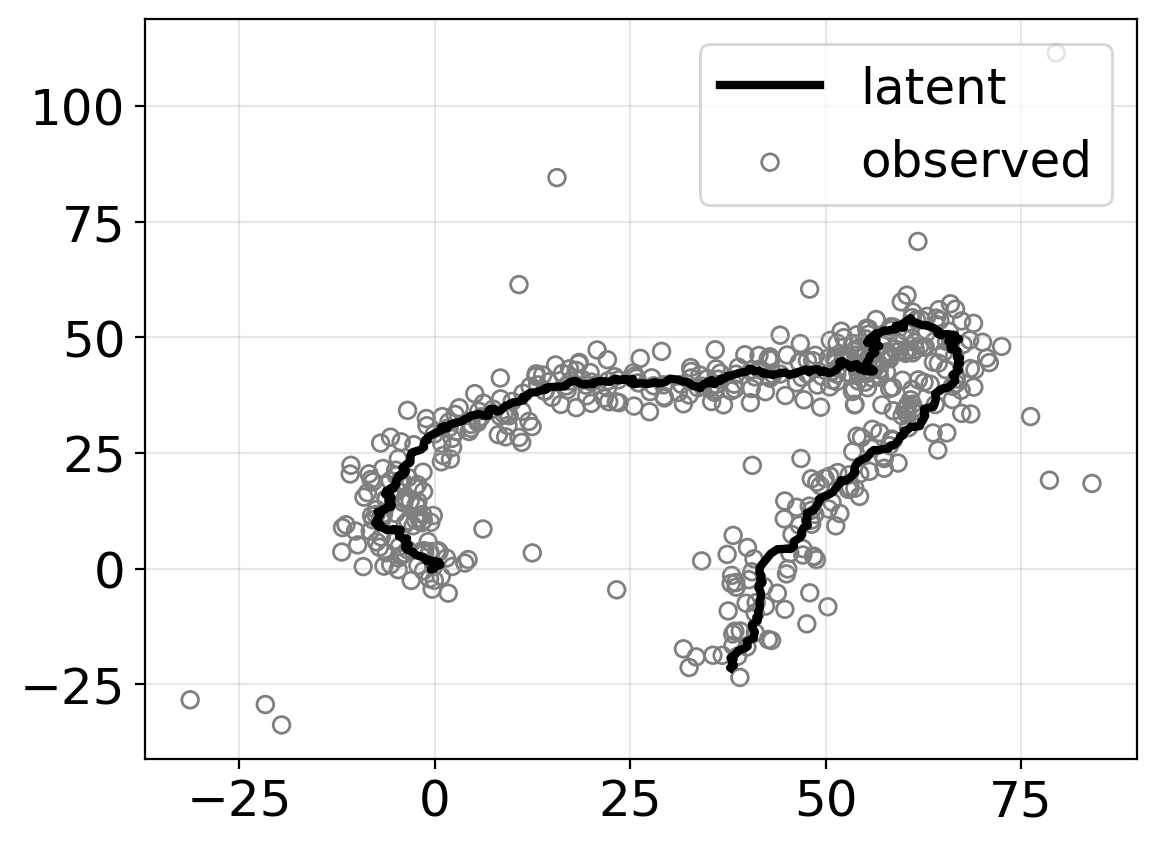

In [26]:
i = 1
latent_i = datasets["latent"][i, :, :2].T
observed_i = yv[i]

plt.plot(*latent_i, c="black", label="latent", linewidth=3)
plt.scatter(*observed_i.T, c="none", edgecolor="tab:gray", label="observed")
plt.legend()
plt.grid(alpha=0.3)
plt.savefig("./figures/2d-ssm-sample-outlier-covariance.pdf")

In [33]:
7.2 / 3 * 2.5

6.0

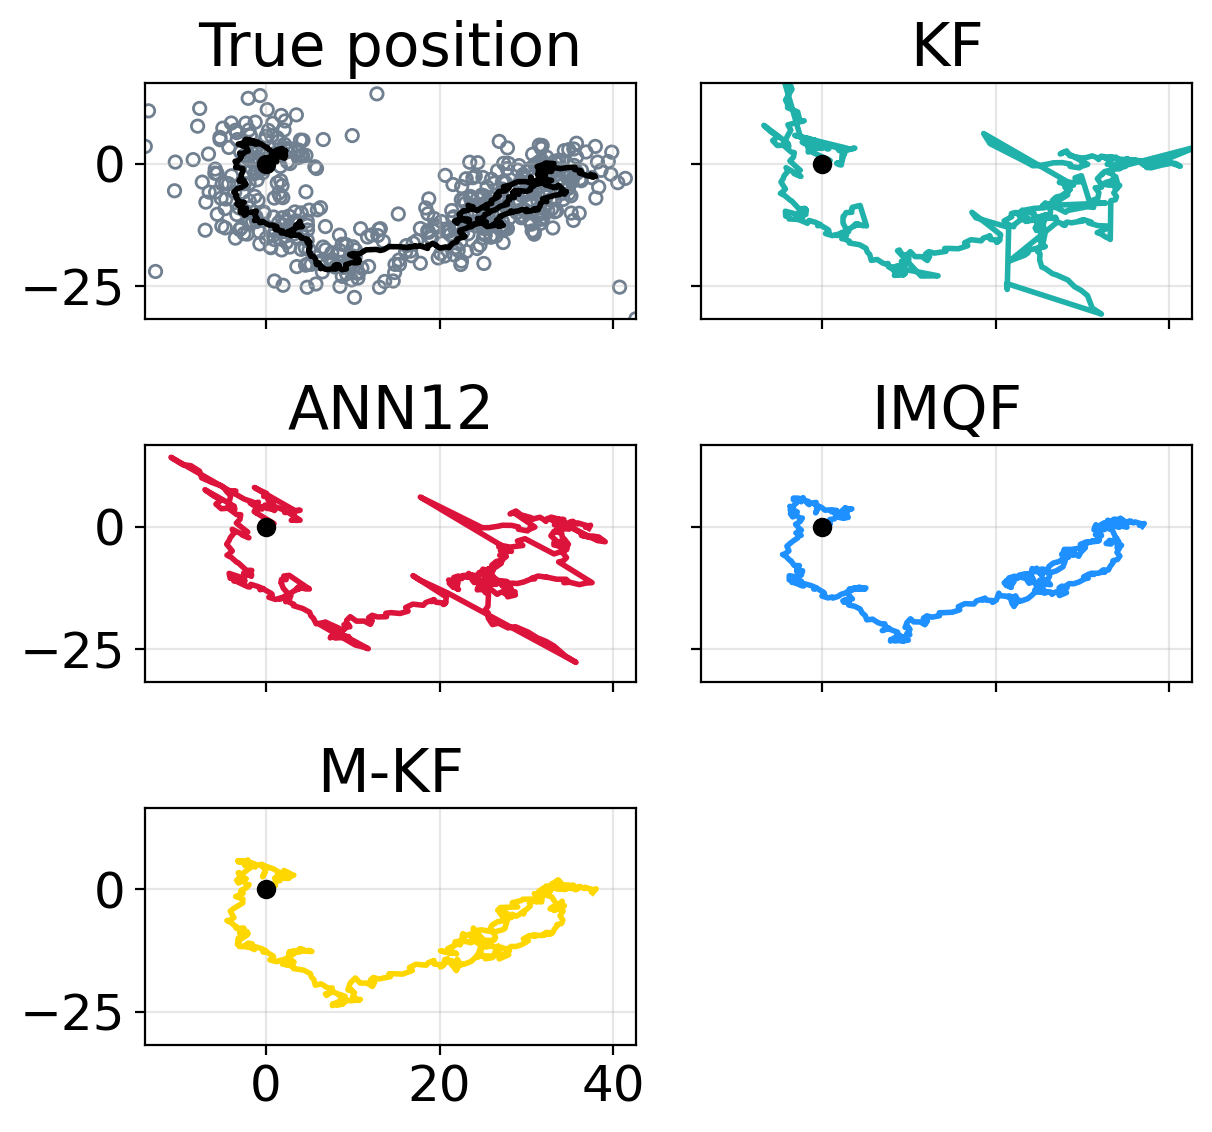

In [34]:
i = 6
latent_i = datasets["latent"][i, :, :2].T
kf_i = hist_bel_kf_runs[i, :, :2].T
rkf_i = hist_bel_rkf_runs[i, :, :2].T
imq_i = hist_bel_imqf_runs[i, :, :2].T
mekf_i = hist_bel_mah_ekf_runs[i, :, :2].T

fig, ax = plt.subplots(3,2, figsize=(6.4, 6.0), sharex=True, sharey=True)

ax[0,0].plot(*latent_i, c="black", linewidth=2)
ax[0,0].set_title("True position")
ax[0,0].scatter(*yv[i, :].T, edgecolor="slategray", color="none", s=20, label="observed")

ylim = ax[0,0].get_ylim()
xlim = ax[0,0].get_xlim()

ax[0,1].plot(*kf_i, c="lightseagreen", linewidth=2)
ax[0,1].set_title("KF")

ax[1,0].plot(*rkf_i, c="crimson", linewidth=2)
ax[1,0].set_title("ANN12")

ax[1,1].plot(*imq_i, c="dodgerblue", linewidth=2)
ax[1,1].set_title("IMQF")


ax[2,0].plot(*mekf_i, c="gold", linewidth=2)
ax[2,0].set_title("M-KF")


(xmin, ymin) = np.quantile(yv[i], 0.01, axis=0)
(xmax, ymax) = np.quantile(yv[i], 0.99, axis=0)
for axi in ax.ravel():
    axi.grid(alpha=0.3)
    axi.scatter(0,0, c="black", zorder=3)
    axi.set_xlim(xmin, xmax)
    axi.set_ylim(ymin, ymax)
    
ax[-1, -1].cla()
ax[-1, -1].axis("off")

plt.tight_layout()
plt.savefig("./figures/2d-ssm-comparison-single-run.pdf")